In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Define the model architecture as shown in the following diagram:

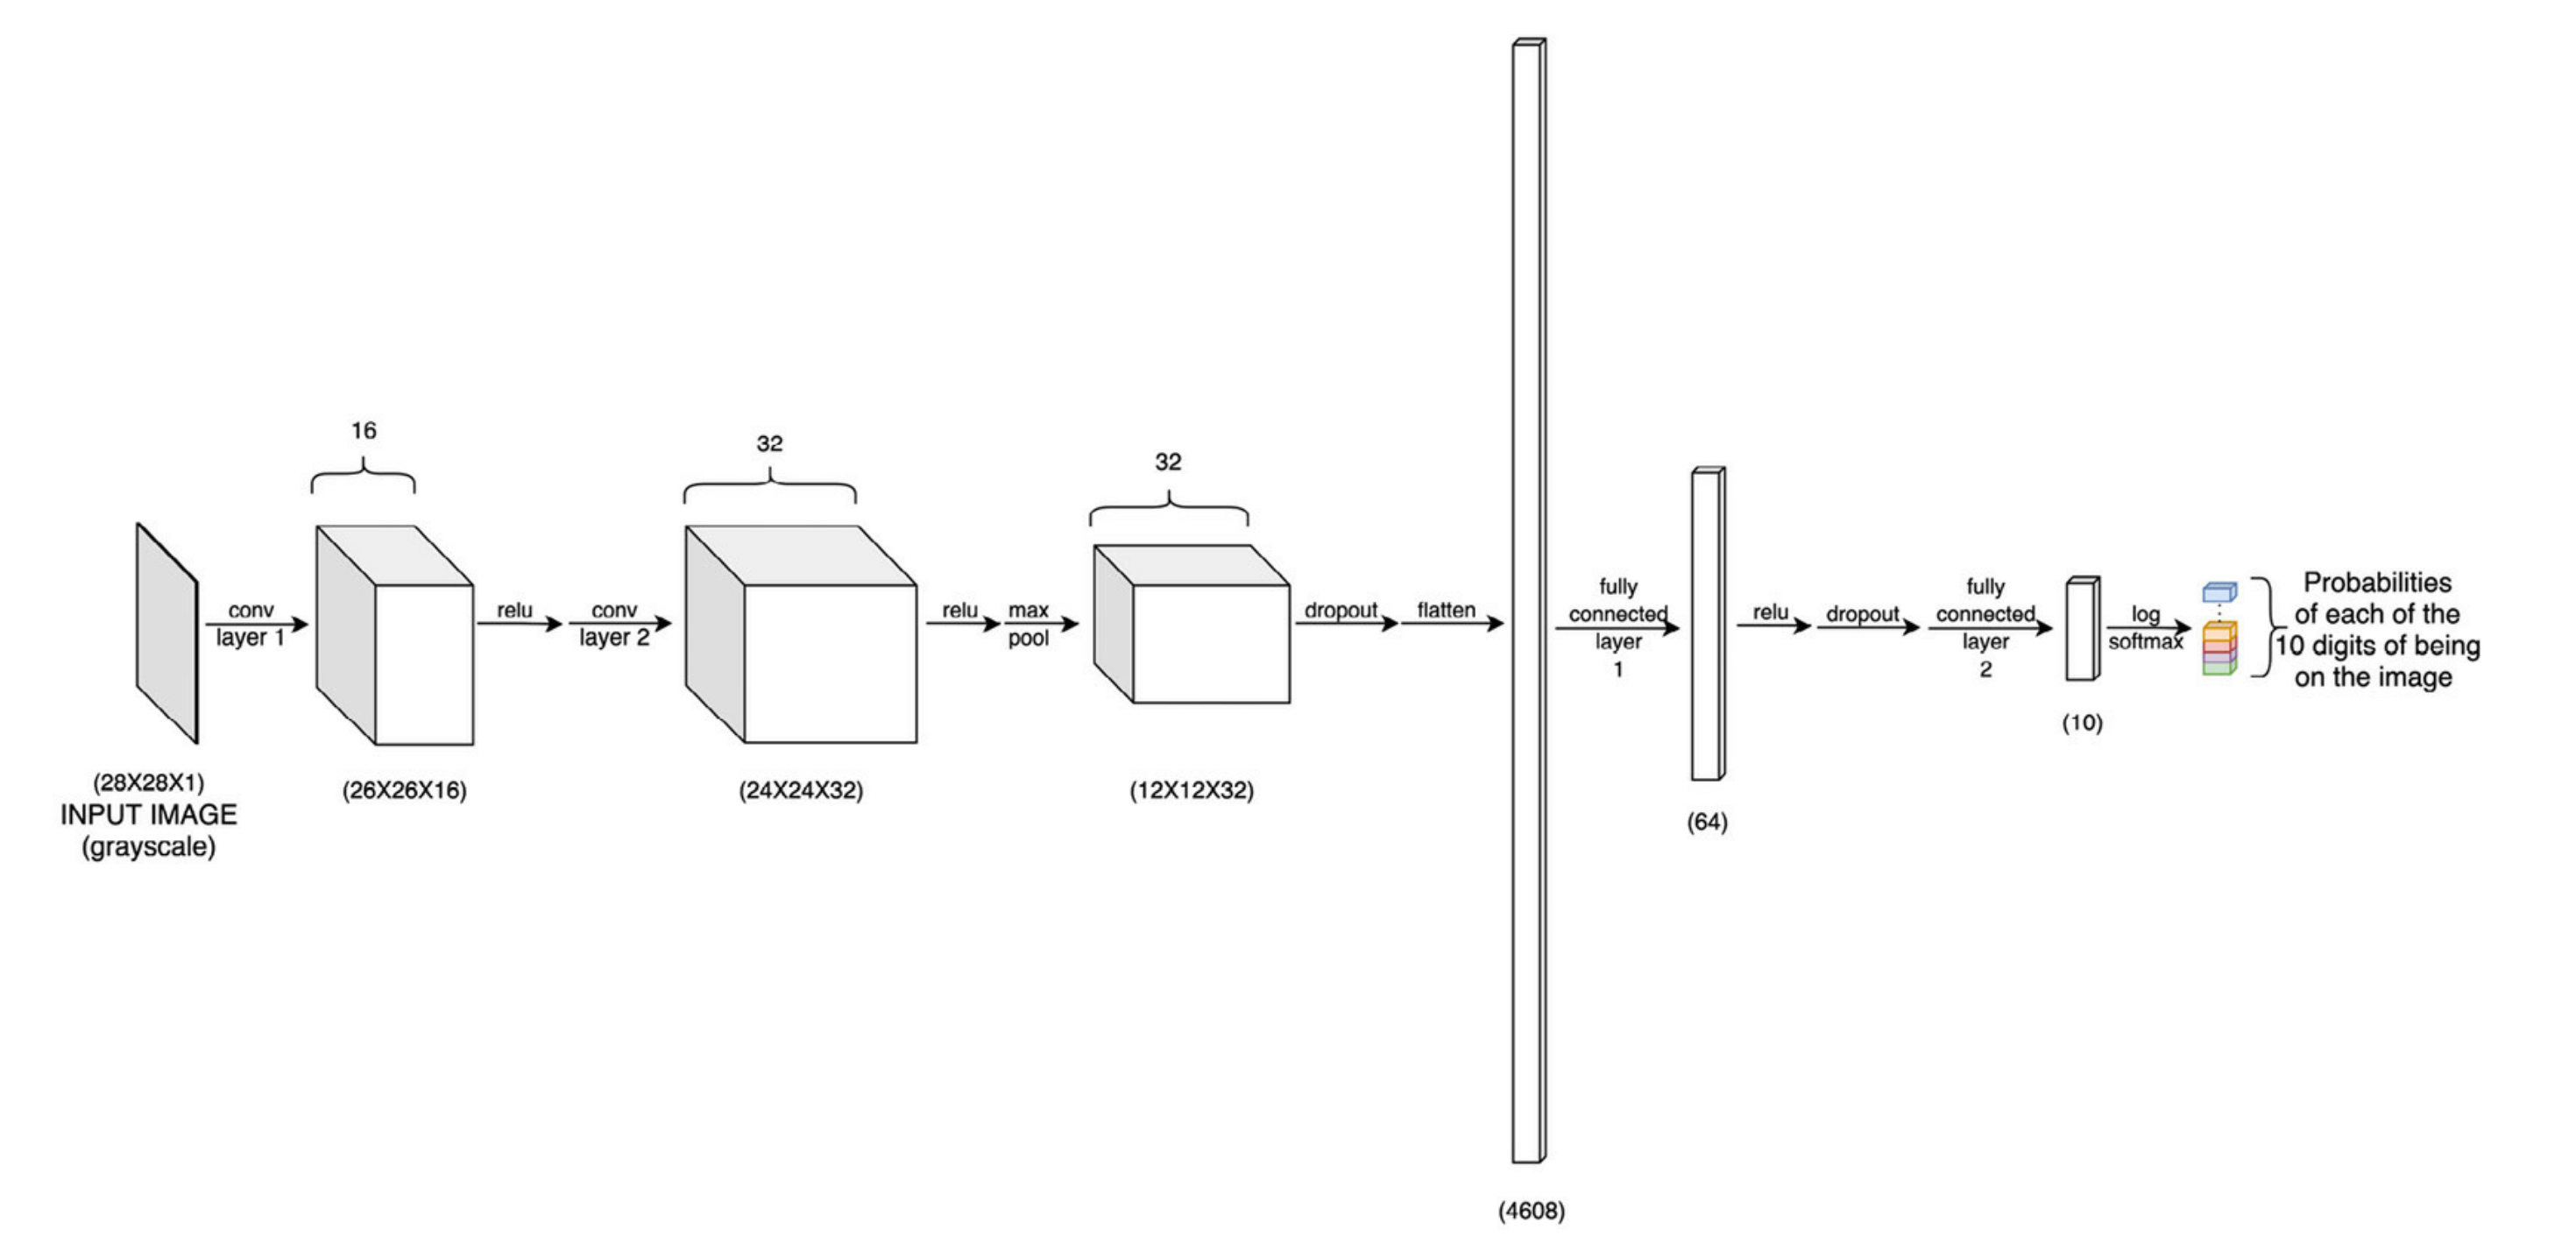

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
    self.dropout1 = nn.Dropout2d(0.1)
    self.dropout2 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(12*12*32, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output


Define the training routine, that is the back-propagation step.

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target) # nll is the negatice likelihood loss
    loss.backward()
    optimizer.step()

    if batch_idx % 200 == 0:
      print('+ Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),  target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() # loss summed across the batch
      pred = output.argmax(dim=1, keepdim=True) # to get the most likely prediction

      # View this tensor as the same size as other. 
      # self.view_as(other) is equivalent to self.view(other.size()).
      correct += pred.eq(target.view_as(pred)).sum().item()
      test_loss /= len(test_loader.dataset)

      print('- Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
              test_loss, 
              correct, 
              len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [ ]:
def minist_dataset(dir, transforms=None):
  train_dataset = datasets.MNIST(dir, 
                              train=True, 
                              download=True,
                              transform=transforms)
  test_dataset = datasets.MNIST(dir, 
                              train=False,
                              transform=transforms)
  
  return train_dataset, test_dataset

In [ ]:
def main():
    # Training settings
    batch_size = 64
    test_batch_size = 1000
    epochs = 5
    lr = 1.0
    gamma = 0.7
    no_cuda = False
    seed = 1
    log_interval = 10
    save_model = False

    use_cuda = not no_cuda and torch.cuda.is_available()
    torch.manual_seed(seed)
    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}

        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    train_dataset, test_dataset = minist_dataset('./data', transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    model = ConvNet().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

In [ ]:
if __name__ == '__main__':
    main()

+ Train Epoch: 1 [0/60000 (0%)] 	Loss: 2.318661
+ Train Epoch: 1 [12800/60000 (21%)] 	Loss: 0.116918
+ Train Epoch: 1 [25600/60000 (43%)] 	Loss: 0.151315
+ Train Epoch: 1 [38400/60000 (64%)] 	Loss: 0.027357
+ Train Epoch: 1 [51200/60000 (85%)] 	Loss: 0.226789
- Test set: Average loss: 0.0046, Accuracy: 982/10000 (10%)
- Test set: Average loss: 0.0050, Accuracy: 1966/10000 (20%)
- Test set: Average loss: 0.0059, Accuracy: 2950/10000 (30%)
- Test set: Average loss: 0.0075, Accuracy: 3930/10000 (39%)
- Test set: Average loss: 0.0031, Accuracy: 4918/10000 (49%)
- Test set: Average loss: 0.0068, Accuracy: 5897/10000 (59%)
- Test set: Average loss: 0.0063, Accuracy: 6878/10000 (69%)
- Test set: Average loss: 0.0046, Accuracy: 7862/10000 (79%)
- Test set: Average loss: 0.0048, Accuracy: 8844/10000 (88%)
- Test set: Average loss: 0.0060, Accuracy: 9826/10000 (98%)
+ Train Epoch: 2 [0/60000 (0%)] 	Loss: 0.042136
+ Train Epoch: 2 [12800/60000 (21%)] 	Loss: 0.031700
+ Train Epoch: 2 [25600/60000 